<a href="https://colab.research.google.com/github/PranavkrishnaVadhyar/Data-augmentation-research/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import Necessary Libraries

In [23]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


# Load Data

In [3]:
# Function to load data
def load_data(data_dir, img_size=(224, 224)):
    images = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, img_size)
                image = image / 255.0
                images.append(image)
                labels.append(class_name)

    return np.array(images), np.array(labels)

# Load the data
data_dir = '/content/drive/MyDrive/Wounds-Types'
X, y = load_data(data_dir)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Data Augmentation

In [4]:
# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_categorical, batch_size=32)
valid_generator = valid_datagen.flow(X_test, y_test_categorical, batch_size=32)


# Build and Compile the ResNet50 Model

In [14]:
# Define the base pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head to the InceptionV3 model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout layer for regularization
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Combine base model and custom head to create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# Set Callbacks and Train the Model

In [24]:
# Callbacks
checkpoint_filepath = '/content/drive/MyDrive/checkpoint.weights.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_inceptionv3_model.h5.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[checkpoint, early_stopping, reduce_lr])

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again for fine-tuning
history_finetune = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[checkpoint, early_stopping, reduce_lr])


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.7233 - loss: 0.7673 - val_accuracy: 0.6071 - val_loss: 1.0766 - learning_rate: 2.0000e-05
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.6998 - loss: 0.8339 - val_accuracy: 0.6190 - val_loss: 1.0692 - learning_rate: 2.0000e-05
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.6550 - loss: 0.8788 - val_accuracy: 0.6190 - val_loss: 1.0578 - learning_rate: 2.0000e-05
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.6666 - loss: 0.8743 - val_accuracy: 0.6190 - val_loss: 1.0543 - learning_rate: 2.0000e-05
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.6773 - loss: 0.8273 - val_accuracy: 0.6071 - val_loss: 1.0601 - learning_rate: 2.0000e-05
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.6986 - loss: 0.8247 - val_accuracy: 0.6190 - val_loss: 1.0595 - learning_rate: 2.0000e-05
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - accuracy: 

# Load Best Model and Evaluate

In [26]:
# Load the best model
model.load_weights('/content/drive/MyDrive/checkpoint.weights.h5')
# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Calculate AUC ROC Score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
mean_auc_roc_score = np.mean(list(roc_auc.values()))

# Print evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC ROC Score:", mean_auc_roc_score)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
Accuracy: 0.6785714285714286
F1 Score: 0.6772442881782718
AUC ROC Score: 0.8277885533346279
Confusion Matrix:
 [[15  5  1  3]
 [ 2 23  0  4]
 [ 2  2  7  3]
 [ 0  3  2 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.62      0.70        24
           1       0.70      0.79      0.74        29
           2       0.70      0.50      0.58        14
           3       0.55      0.71      0.62        17

    accuracy                           0.68        84
   macro avg       0.68      0.66      0.66        84
weighted avg       0.69      0.68      0.68        84



# Plot Learning Curves

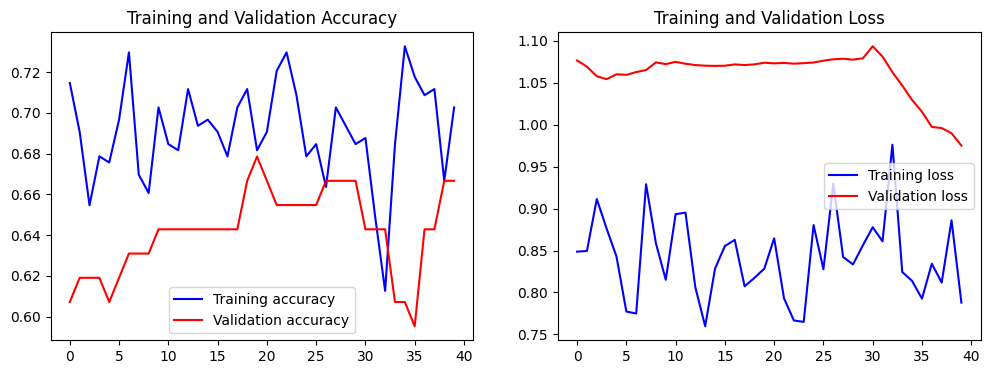

In [27]:
# Plot learning curves
def plot_learning_curves(history, history_finetune):
    acc = history.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history.history['loss'] + history_finetune.history['loss']
    val_loss = history.history['val_loss'] + history_finetune.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_learning_curves(history, history_finetune)


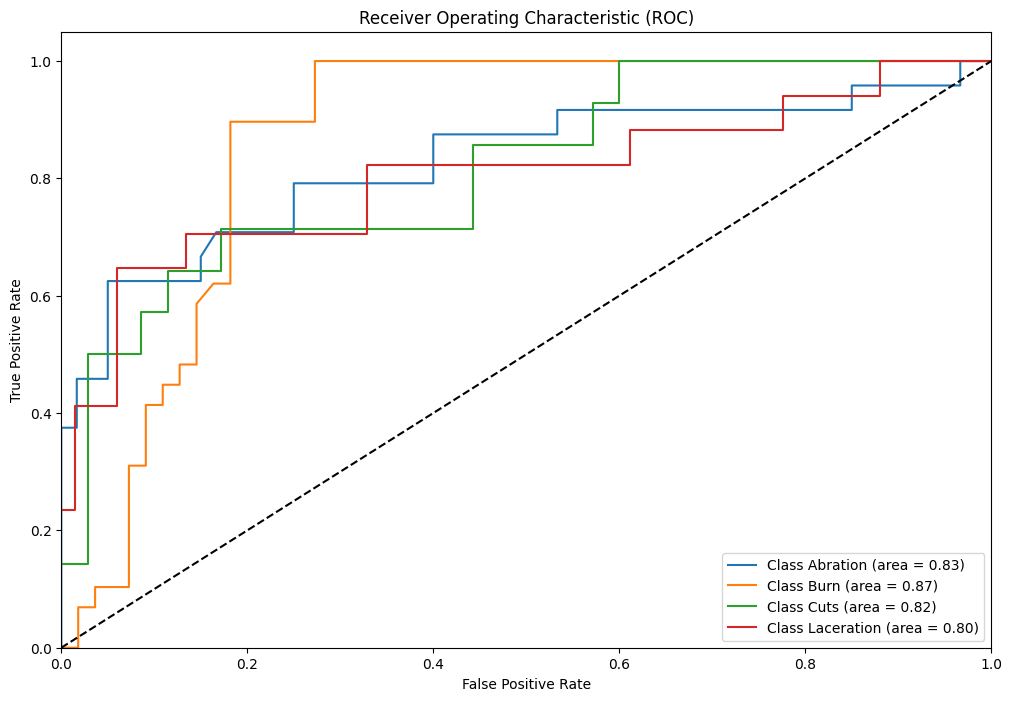

In [28]:
# Plot AUC ROC curves
plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [29]:
model.save('/content/drive/MyDrive/my_inceptionv3_model.h5')


In [30]:
model.save('my_model.keras')